<a href="https://colab.research.google.com/github/itinasharma/MachineLearning/blob/main/Zero_Inflated_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**❌The Problem**

/tmp/ipython-input-2490800448.py:102: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


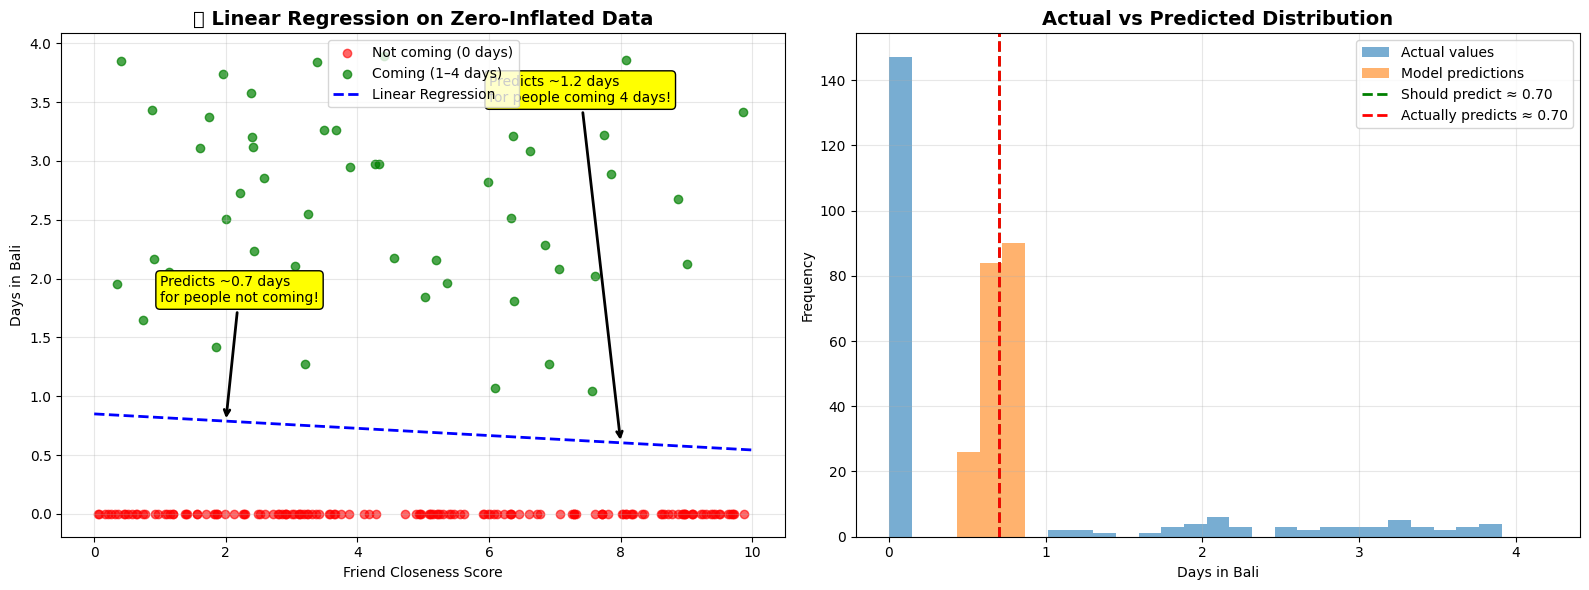


DETAILED BREAKDOWN BY GROUP
                     Count  Actual_Avg  Predicted_Avg  Error
Group                                                       
Coming 1–2 days         12        1.59           0.73   0.85
Coming 2–3 days         21        2.47           0.70   1.76
Coming 3–4 days         20        3.47           0.71   2.76
Not coming (0 days)    147        0.00           0.70   0.70


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

np.random.seed(42)

# ------------------------------------------------------------
# 1. Generate zero-inflated data (unknown to the model)
# ------------------------------------------------------------
n = 200

friend_closeness = np.random.uniform(0, 10, n)

# Zero-inflated target
y = []
for _ in range(n):
    if np.random.rand() < 0.75:
        y.append(0.0)                       # Not coming
    else:
        y.append(np.random.uniform(1, 4))   # Coming 1–4 days

y = np.array(y)

# Feature matrix
X = friend_closeness.reshape(-1, 1)

# ------------------------------------------------------------
# 2. Fit naive linear regression (WRONG model)
# ------------------------------------------------------------
lr = LinearRegression()
lr.fit(X, y)

y_pred = lr.predict(X)

# ------------------------------------------------------------
# 3. Create figure layout
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ============================================================
# LEFT: Linear regression scatter (failure)
# ============================================================
ax = axes[0]

# Plot actual data
ax.scatter(friend_closeness[y == 0], y[y == 0],
           color='red', alpha=0.6, label='Not coming (0 days)')
ax.scatter(friend_closeness[y > 0], y[y > 0],
           color='green', alpha=0.7, label='Coming (1–4 days)')

# Regression line
x_line = np.linspace(0, 10, 100)
y_line = lr.predict(x_line.reshape(-1, 1))
ax.plot(x_line, y_line, linestyle='--', color='blue',
        linewidth=2, label='Linear Regression')

# Annotations
ax.annotate('Predicts ~0.7 days\nfor people not coming!',
            xy=(2, lr.predict([[2]])[0]),
            xytext=(1, 1.8),
            arrowprops=dict(arrowstyle='->', lw=2),
            fontsize=10,
            bbox=dict(boxstyle='round', facecolor='yellow'))

ax.annotate('Predicts ~1.2 days\nfor people coming 4 days!',
            xy=(8, lr.predict([[8]])[0]),
            xytext=(6, 3.5),
            arrowprops=dict(arrowstyle='->', lw=2),
            fontsize=10,
            bbox=dict(boxstyle='round', facecolor='yellow'))

ax.set_title('❌ Linear Regression on Zero-Inflated Data',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Friend Closeness Score')
ax.set_ylabel('Days in Bali')
ax.legend()
ax.grid(alpha=0.3)

# ============================================================
# RIGHT: Actual vs Predicted distribution
# ============================================================
ax2 = axes[1]

bins = np.linspace(0, 4.2, 30)

ax2.hist(y, bins=bins, alpha=0.6, label='Actual values')
ax2.hist(y_pred, bins=bins, alpha=0.6, label='Model predictions')

ax2.axvline(np.mean(y), linestyle='--', color='green',
            linewidth=2, label=f'Should predict ≈ {np.mean(y):.2f}')
ax2.axvline(np.mean(y_pred), linestyle='--', color='red',
            linewidth=2, label=f'Actually predicts ≈ {np.mean(y_pred):.2f}')

ax2.set_title('Actual vs Predicted Distribution',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Days in Bali')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4. Diagnostic breakdown table (this is key)
# ------------------------------------------------------------
df = pd.DataFrame({
    'Actual': y,
    'Predicted': y_pred
})

def bucket(days):
    if days == 0:
        return 'Not coming (0 days)'
    elif days <= 2:
        return 'Coming 1–2 days'
    elif days <= 3:
        return 'Coming 2–3 days'
    else:
        return 'Coming 3–4 days'

df['Group'] = df['Actual'].apply(bucket)

summary = (
    df.groupby('Group')
      .agg(
          Count=('Actual', 'count'),
          Actual_Avg=('Actual', 'mean'),
          Predicted_Avg=('Predicted', 'mean')
      )
)

summary['Error'] = abs(summary['Actual_Avg'] -
                       summary['Predicted_Avg'])

print("\n" + "="*60)
print("DETAILED BREAKDOWN BY GROUP")
print("="*60)
print(summary.round(2))


#**The distribution of days in Bali shows a massive spike at zero**

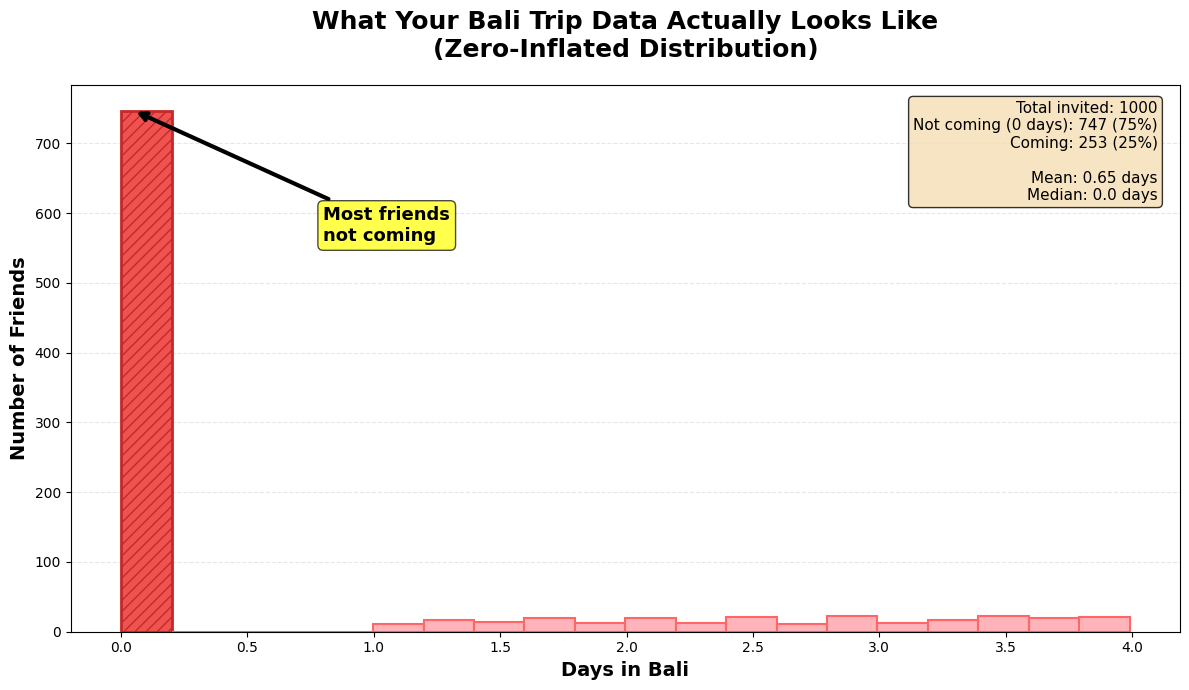


SINGLE-PROCESS ASSUMPTION CHECK
Fitted Normal distribution:
  Mean (μ): 0.65
  Std Dev (σ): 1.20

Observed zeros:
  Count: 747
  Percentage: 74.7%

Expected zeros under a single continuous process:
  Expected count (X ≤ 0): 293.54
  Expected percentage: 29.35%

Zero inflation factor:
  Observed zeros are ~2.5× higher than expected

Technical conclusion:
  A single continuous distribution cannot plausibly generate
  this many exact zeros. The data must arise from at least
  two different data-generating processes:
  (1) a binary decision to come or not
  (2) a duration decision conditional on coming


In [2]:
"""
Zero-Inflated Distribution: Bali Trip Example

This script:
1. Visualizes the raw target distribution (histogram)
2. Performs a technical diagnostic to test whether a single
   continuous process could plausibly generate the observed zeros
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ------------------------------------------------------------
# 1. DATA GENERATION
# ------------------------------------------------------------
np.random.seed(42)

def generate_zero_inflated_data(n=1000, zero_prob=0.75):
    """
    Synthetic Bali trip data
    0 days = not coming
    1–4 days = coming
    """
    data = []
    for _ in range(n):
        if np.random.rand() < zero_prob:
            data.append(0)
        else:
            data.append(np.random.uniform(1, 4))
    return np.array(data)

data = generate_zero_inflated_data(n=1000, zero_prob=0.75)

# Basic stats
zero_count = np.sum(data == 0)
zero_pct = zero_count / len(data) * 100
non_zero_count = len(data) - zero_count

# ------------------------------------------------------------
# 2. VISUAL: RAW DISTRIBUTION (SETUP FIGURE)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 7))

bins = 20
counts, bin_edges, patches = ax.hist(
    data,
    bins=bins,
    edgecolor="black",
    linewidth=1.5
)

# Highlight zero bar
patches[0].set_facecolor("#ef5350")
patches[0].set_edgecolor("#c62828")
patches[0].set_linewidth(2)
patches[0].set_hatch("///")

# Color remaining bins
for patch in patches[1:]:
    patch.set_facecolor("#ffb3ba")
    patch.set_edgecolor("#ff6666")

ax.set_title(
    "What Your Bali Trip Data Actually Looks Like\n(Zero-Inflated Distribution)",
    fontsize=18,
    fontweight="bold",
    pad=20
)
ax.set_xlabel("Days in Bali", fontsize=14, fontweight="bold")
ax.set_ylabel("Number of Friends", fontsize=14, fontweight="bold")

# Annotation
ax.annotate(
    "Most friends\nnot coming",
    xy=(0.05, counts[0]),
    xytext=(0.8, counts[0] * 0.75),
    arrowprops=dict(arrowstyle="->", lw=3),
    fontsize=13,
    fontweight="bold",
    bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.7)
)

# Stats box
stats_text = (
    f"Total invited: {len(data)}\n"
    f"Not coming (0 days): {zero_count} ({zero_pct:.0f}%)\n"
    f"Coming: {non_zero_count} ({100-zero_pct:.0f}%)\n\n"
    f"Mean: {np.mean(data):.2f} days\n"
    f"Median: {np.median(data):.1f} days"
)

ax.text(
    0.98, 0.97, stats_text,
    transform=ax.transAxes,
    fontsize=11,
    va="top",
    ha="right",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8)
)

ax.grid(axis="y", alpha=0.3, linestyle="--")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3. TECHNICAL DIAGNOSTIC (THIS IS THE REAL WORK)
# ------------------------------------------------------------
# Question:
# If this were ONE continuous process, how many zeros should exist?

mu, sigma = norm.fit(data)

expected_zero_prob = norm.cdf(0, mu, sigma)
expected_zero_count = expected_zero_prob * len(data)
inflation_factor = zero_count / max(expected_zero_count, 1e-6)

print("\n" + "=" * 70)
print("SINGLE-PROCESS ASSUMPTION CHECK")
print("=" * 70)

print(f"Fitted Normal distribution:")
print(f"  Mean (μ): {mu:.2f}")
print(f"  Std Dev (σ): {sigma:.2f}")

print(f"\nObserved zeros:")
print(f"  Count: {zero_count}")
print(f"  Percentage: {zero_pct:.1f}%")

print(f"\nExpected zeros under a single continuous process:")
print(f"  Expected count (X ≤ 0): {expected_zero_count:.2f}")
print(f"  Expected percentage: {expected_zero_prob*100:.2f}%")

print(f"\nZero inflation factor:")
print(f"  Observed zeros are ~{inflation_factor:.1f}× higher than expected")

print("\nTechnical conclusion:")
print(
    "  A single continuous distribution cannot plausibly generate\n"
    "  this many exact zeros. The data must arise from at least\n"
    "  two different data-generating processes:\n"
    "  (1) a binary decision to come or not\n"
    "  (2) a duration decision conditional on coming"
)

print("=" * 70)


#**Each row represents a friend's data. The distribution reveals the pattern.**

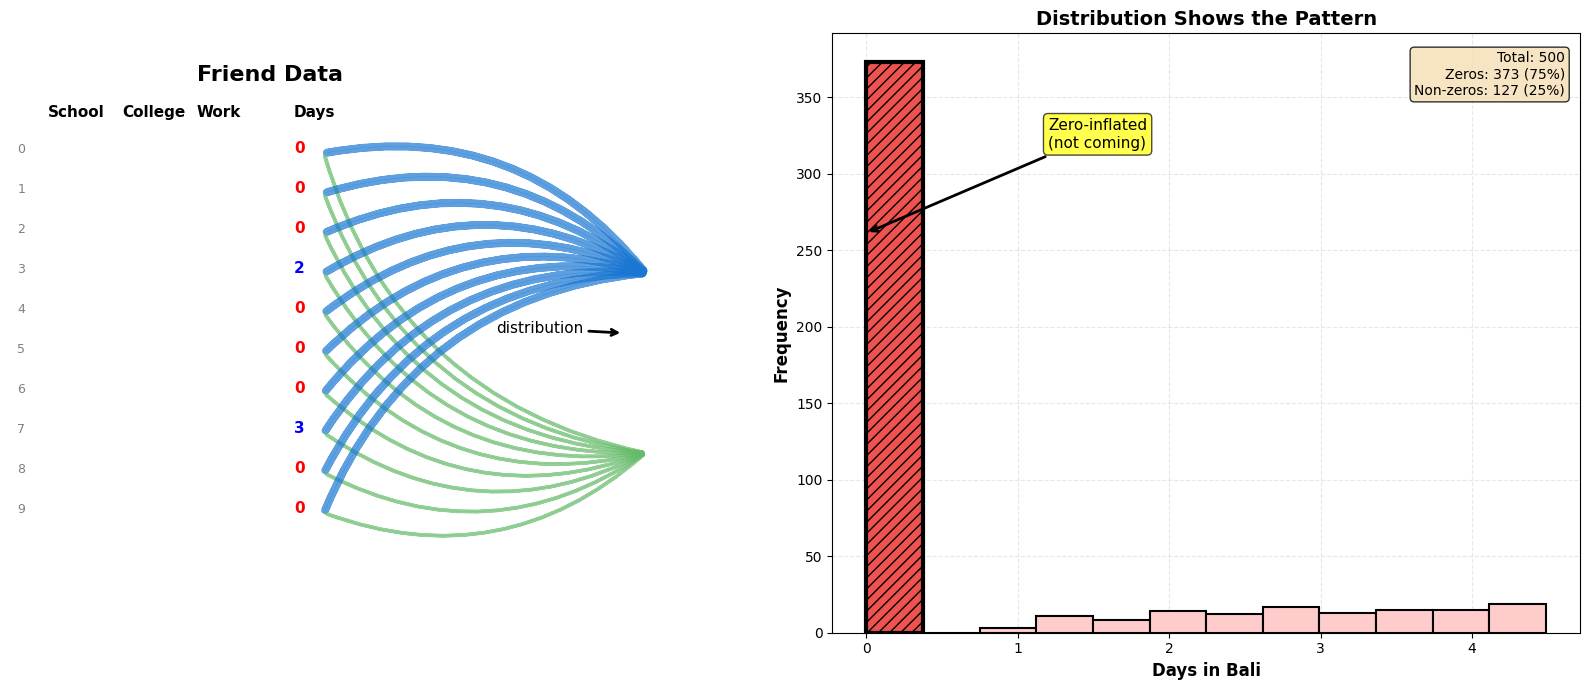

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

np.random.seed(42)

# ------------------------------------------------------------
# 1. Generate data (real counts drive everything)
# ------------------------------------------------------------
def generate_data(n=500, zero_prob=0.75):
    data = []
    for _ in range(n):
        if np.random.rand() < zero_prob:
            data.append(0)
        else:
            data.append(np.random.uniform(1, 4.5))
    return np.array(data)

data = generate_data()

zeros = np.sum(data == 0)
nonzeros = np.sum(data > 0)

# ------------------------------------------------------------
# 2. Figure layout
# ------------------------------------------------------------
fig = plt.figure(figsize=(16, 7))

# ============================================================
# LEFT: AGGREGATION DIAGRAM (conceptual, not a table)
# ============================================================
ax1 = plt.subplot(1, 2, 1)
ax1.axis("off")

# Header
ax1.text(0.25, 0.92, "Friend Data", fontsize=16, fontweight="bold")

headers = ["School", "College", "Work", "Days"]
x_positions = [0.05, 0.15, 0.25, 0.38]

for x, h in zip(x_positions, headers):
    ax1.text(x, 0.86, h, fontsize=11, fontweight="bold")

# Symbolic rows
rows = 10
y_positions = np.linspace(0.8, 0.2, rows)
sample_values = [0, 0, 0, 2, 0, 0, 0, 3, 0, 0]

for i, y in enumerate(y_positions):
    ax1.text(0.01, y, f"{i}", fontsize=9, color="gray")
    ax1.text(0.38, y, str(sample_values[i]),
             color="red" if sample_values[i] == 0 else "blue",
             fontsize=11, fontweight="bold")

# Aggregation flows
zero_weight = zeros / len(data)
nonzero_weight = nonzeros / len(data)

for y in y_positions:
    # Zero flows (dominant)
    ax1.add_patch(FancyArrowPatch(
        (0.42, y), (0.85, 0.6),
        connectionstyle="arc3,rad=-0.3",
        linewidth=1 + 6 * zero_weight,
        color="#1976d2",
        alpha=0.7
    ))

    # Non-zero flows
    ax1.add_patch(FancyArrowPatch(
        (0.42, y), (0.85, 0.3),
        connectionstyle="arc3,rad=0.3",
        linewidth=1 + 6 * nonzero_weight,
        color="#66bb6a",
        alpha=0.7
    ))

# Arrow label
ax1.annotate("distribution",
             xy=(0.82, 0.5),
             xytext=(0.65, 0.5),
             arrowprops=dict(arrowstyle="->", lw=2),
             fontsize=11)

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# ============================================================
# RIGHT: HISTOGRAM (result of aggregation)
# ============================================================
ax2 = plt.subplot(1, 2, 2)

bins = 12
counts, edges, patches = ax2.hist(data, bins=bins,
                                  edgecolor="black",
                                  linewidth=1.5)

# Highlight zero bin
patches[0].set_facecolor("#ef5350")
patches[0].set_hatch("///")
patches[0].set_linewidth(3)

for p in patches[1:]:
    p.set_facecolor("#ffcccc")

ax2.set_title("Distribution Shows the Pattern",
              fontsize=14, fontweight="bold")
ax2.set_xlabel("Days in Bali", fontsize=12, fontweight="bold")
ax2.set_ylabel("Frequency", fontsize=12, fontweight="bold")
ax2.grid(alpha=0.3, linestyle="--")
ax2.set_axisbelow(True)

# Annotation
ax2.annotate("Zero-inflated\n(not coming)",
             xy=(0, counts[0] * 0.7),
             xytext=(1.2, counts[0] * 0.85),
             arrowprops=dict(arrowstyle="->", lw=2),
             fontsize=11,
             bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.7))

# Stats box
ax2.text(0.98, 0.97,
         f"Total: {len(data)}\n"
         f"Zeros: {zeros} ({zeros/len(data)*100:.0f}%)\n"
         f"Non-zeros: {nonzeros} ({nonzeros/len(data)*100:.0f}%)",
         transform=ax2.transAxes,
         ha="right", va="top",
         fontsize=10,
         bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

plt.tight_layout()
plt.show()


#**Linear regression forces one line through everything, making poor predictions for both zeros and non-zeros**

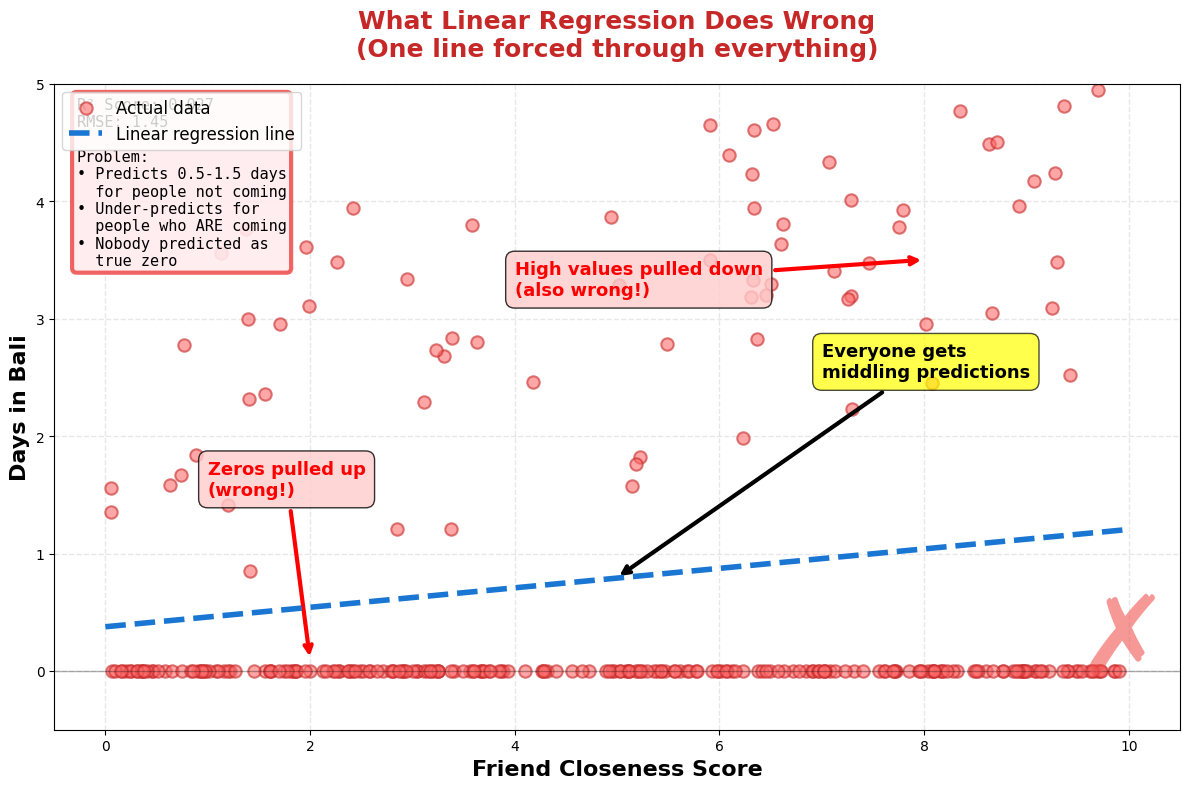

LINEAR REGRESSION ON ZERO-INFLATED DATA: BALI TRIP

Data Overview:
  Total friends invited: 300
  Not coming (0 days): 226 (75.3%)
  Coming (>0 days): 74 (24.7%)

Model Performance:
  R² Score: 0.027
  RMSE: 1.45 days

Actual Data Statistics:
  Mean: 0.79 days
  Median: 0.00 days
  Mean (among those coming): 3.19 days

Model Predictions:
  Prediction range: 0.38 to 1.20 days
  Average prediction: 0.79 days

For friends NOT coming (actual = 0 days):
  Model predicts: 0.38 to 1.20 days
  Average prediction: 0.78 days
  ❌ WRONG! Should predict 0 days

For friends who ARE coming (actual = 1-4 days):
  Actual range: 0.85 to 5.20 days
  Model predicts: 0.38 to 1.18 days
  Average error: 2.37 days
  ❌ Under-predicts duration

KEY PROBLEM:
The model is not broken. The assumption is.

Linear regression assumes all values come from the same
continuous distribution. But they don't:
  • Zeros come from one decision: 'I'm not coming'
  • Non-zeros come from another: 'I'll come for X days'

By forci

In [4]:
"""
Linear Regression on Zero-Inflated Data (Poor Fit)
Shows how standard linear regression struggles with zero-inflated data

This visualization demonstrates why linear regression fails on zero-inflated data:
it forces one line through everything, making poor predictions for both zeros and non-zeros.
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

def generate_bali_trip_data(n=300, zero_prob=0.75):
    """
    Generate zero-inflated data for Bali trip example

    Parameters:
    - n: number of samples (friends invited)
    - zero_prob: probability of not coming (getting zero)

    Returns:
    - X: Friend closeness score (0-10)
    - y: Days in Bali (0 for not coming, 1-4 for coming)
    """
    X = np.random.uniform(0, 10, n)
    y = np.zeros(n)

    for i in range(n):
        if np.random.random() < zero_prob:
            # Not coming to Bali (0 days)
            y[i] = 0
        else:
            # Coming to Bali - duration increases slightly with closeness
            # But there's a lot of randomness (other factors like budget, schedule)
            y[i] = 0.2 * X[i] + np.random.uniform(0.5, 3.5)

    return X.reshape(-1, 1), y

# Generate data
X, y = generate_bali_trip_data(n=300, zero_prob=0.75)

# Fit linear regression on ALL data (this is the wrong approach)
model = LinearRegression()
model.fit(X, y)

# Generate predictions for plotting
X_plot = np.linspace(0, 10, 100).reshape(-1, 1)
y_pred_plot = model.predict(X_plot)

# Calculate metrics
y_pred_all = model.predict(X)
r2 = r2_score(y, y_pred_all)
rmse = np.sqrt(mean_squared_error(y, y_pred_all))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot of actual data
ax.scatter(X, y, alpha=0.6, s=80,
          color='#ff6b6b',
          edgecolor='#c62828',
          linewidth=1.5,
          label='Actual data')

# Linear regression line
ax.plot(X_plot, y_pred_plot,
       color='#1976d2',
       linewidth=4,
       label='Linear regression line',
       linestyle='--',
       zorder=5)

# Styling
ax.set_xlabel('Friend Closeness Score', fontsize=16, fontweight='bold')
ax.set_ylabel('Days in Bali', fontsize=16, fontweight='bold')
ax.set_title('What Linear Regression Does Wrong\n(One line forced through everything)',
            fontsize=18, fontweight='bold', pad=20, color='#c62828')

ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-0.5, 5)

ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)
ax.set_axisbelow(True)
ax.legend(fontsize=12, loc='upper left')

# Add annotations highlighting the problems

# 1. Annotation for zeros being pulled up
ax.annotate('Zeros pulled up\n(wrong!)',
            xy=(2, 0.1),
            xytext=(1, 1.5),
            arrowprops=dict(arrowstyle='->', lw=3, color='red'),
            fontsize=13,
            fontweight='bold',
            color='red',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#ffcccc', alpha=0.8))

# 2. Annotation for high values being pulled down
ax.annotate('High values pulled down\n(also wrong!)',
            xy=(8, 3.5),
            xytext=(4, 3.2),
            arrowprops=dict(arrowstyle='->', lw=3, color='red'),
            fontsize=13,
            fontweight='bold',
            color='red',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#ffcccc', alpha=0.8))

# 3. Annotation for middling predictions
mid_pred_val = y_pred_plot[50]
ax.annotate('Everyone gets\nmiddling predictions',
            xy=(5, mid_pred_val),
            xytext=(7, 2.5),
            arrowprops=dict(arrowstyle='->', lw=3, color='black'),
            fontsize=13,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Add horizontal line at zero
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)

# Add metrics text box
textstr = (f'R² Score: {r2:.3f}\n'
           f'RMSE: {rmse:.2f}\n\n'
           f'Problem:\n'
           f'• Predicts 0.5-1.5 days\n'
           f'  for people not coming\n'
           f'• Under-predicts for\n'
           f'  people who ARE coming\n'
           f'• Nobody predicted as\n'
           f'  true zero')

props = dict(boxstyle='round', facecolor='#ffebee', alpha=0.9,
             edgecolor='#ef5350', linewidth=3)
ax.text(0.02, 0.98, textstr,
       transform=ax.transAxes,
       fontsize=11,
       verticalalignment='top',
       bbox=props,
       family='monospace')

# Add a big red X to emphasize this is wrong
ax.text(0.95, 0.05, '✗',
       transform=ax.transAxes,
       fontsize=80,
       color='#ef5350',
       fontweight='bold',
       ha='center',
       va='bottom',
       alpha=0.6)

plt.tight_layout()
plt.savefig('linear_regression_poor_fit_bali.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed analysis
print("=" * 70)
print("LINEAR REGRESSION ON ZERO-INFLATED DATA: BALI TRIP")
print("=" * 70)
print(f"\nData Overview:")
print(f"  Total friends invited: {len(X)}")

# Analyze zeros vs non-zeros
zero_mask = y == 0
nonzero_mask = y > 0
zero_count = np.sum(zero_mask)
nonzero_count = np.sum(nonzero_mask)

print(f"  Not coming (0 days): {zero_count} ({zero_count/len(y)*100:.1f}%)")
print(f"  Coming (>0 days): {nonzero_count} ({nonzero_count/len(y)*100:.1f}%)")

print(f"\nModel Performance:")
print(f"  R² Score: {r2:.3f}")
print(f"  RMSE: {rmse:.2f} days")

print(f"\nActual Data Statistics:")
print(f"  Mean: {np.mean(y):.2f} days")
print(f"  Median: {np.median(y):.2f} days")
if nonzero_count > 0:
    print(f"  Mean (among those coming): {np.mean(y[nonzero_mask]):.2f} days")

print(f"\nModel Predictions:")
print(f"  Prediction range: {np.min(y_pred_all):.2f} to {np.max(y_pred_all):.2f} days")
print(f"  Average prediction: {np.mean(y_pred_all):.2f} days")

# Show what model predicts for people who aren't coming
zero_predictions = y_pred_all[zero_mask]
print(f"\nFor friends NOT coming (actual = 0 days):")
print(f"  Model predicts: {np.min(zero_predictions):.2f} to {np.max(zero_predictions):.2f} days")
print(f"  Average prediction: {np.mean(zero_predictions):.2f} days")
print(f"  ❌ WRONG! Should predict 0 days")

# Show what model predicts for people who are coming
if nonzero_count > 0:
    nonzero_predictions = y_pred_all[nonzero_mask]
    nonzero_actual = y[nonzero_mask]
    print(f"\nFor friends who ARE coming (actual = 1-4 days):")
    print(f"  Actual range: {np.min(nonzero_actual):.2f} to {np.max(nonzero_actual):.2f} days")
    print(f"  Model predicts: {np.min(nonzero_predictions):.2f} to {np.max(nonzero_predictions):.2f} days")
    print(f"  Average error: {np.mean(np.abs(nonzero_actual - nonzero_predictions)):.2f} days")
    print(f"  ❌ Under-predicts duration")

print(f"\n" + "=" * 70)
print("KEY PROBLEM:")
print("=" * 70)
print("The model is not broken. The assumption is.")
print("")
print("Linear regression assumes all values come from the same")
print("continuous distribution. But they don't:")
print("  • Zeros come from one decision: 'I'm not coming'")
print("  • Non-zeros come from another: 'I'll come for X days'")
print("")
print("By forcing one line through everything, the model:")
print("  1. Pulls zeros upward (predicts 0.5-1.5 instead of 0)")
print("  2. Pulls high values downward (predicts 2 instead of 4)")
print("  3. Gives everyone middling predictions")
print("=" * 70)

#**The two-model approach: Classifier decides who's coming, regressor predicts duration for those who are**

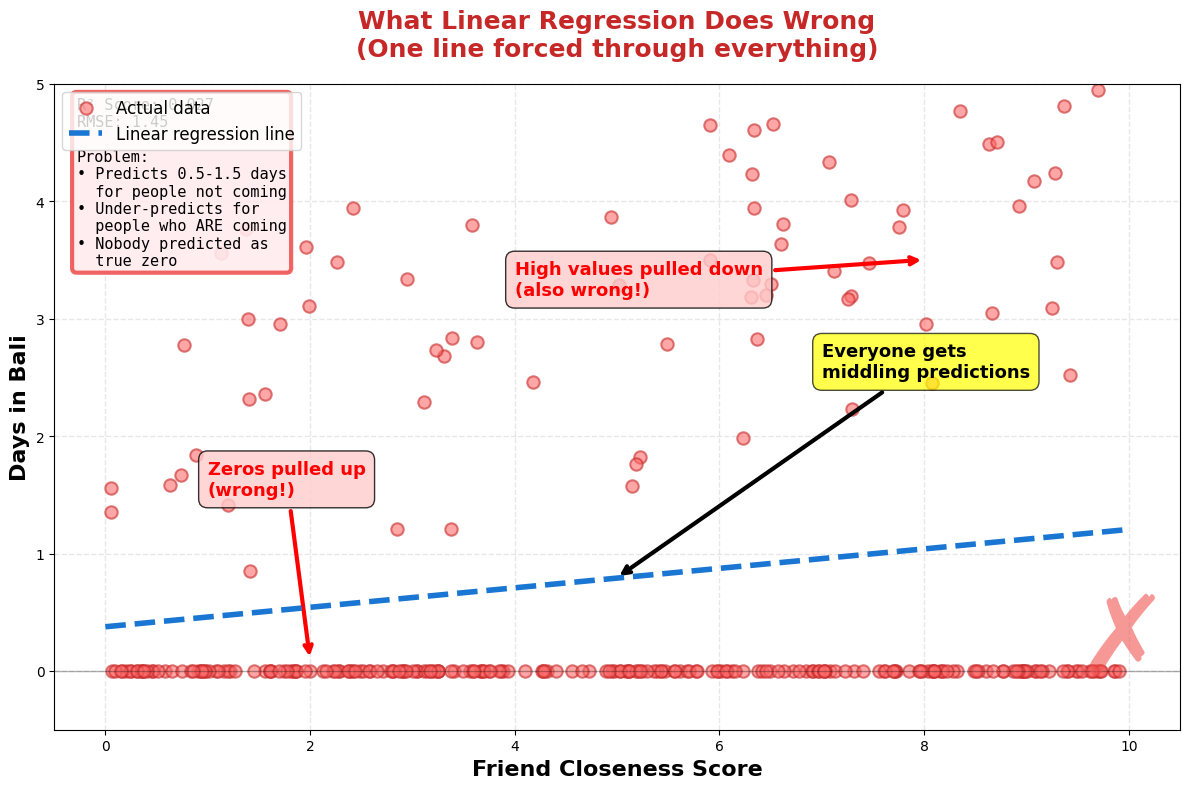

LINEAR REGRESSION ON ZERO-INFLATED DATA: BALI TRIP

Data Overview:
  Total friends invited: 300
  Not coming (0 days): 226 (75.3%)
  Coming (>0 days): 74 (24.7%)

Model Performance:
  R² Score: 0.027
  RMSE: 1.45 days

Actual Data Statistics:
  Mean: 0.79 days
  Median: 0.00 days
  Mean (among those coming): 3.19 days

Model Predictions:
  Prediction range: 0.38 to 1.20 days
  Average prediction: 0.79 days

For friends NOT coming (actual = 0 days):
  Model predicts: 0.38 to 1.20 days
  Average prediction: 0.78 days
  ❌ WRONG! Should predict 0 days

For friends who ARE coming (actual = 1-4 days):
  Actual range: 0.85 to 5.20 days
  Model predicts: 0.38 to 1.18 days
  Average error: 2.37 days
  ❌ Under-predicts duration

KEY PROBLEM:
The model is not broken. The assumption is.

Linear regression assumes all values come from the same
continuous distribution. But they don't:
  • Zeros come from one decision: 'I'm not coming'
  • Non-zeros come from another: 'I'll come for X days'

By forci

In [5]:
"""
Linear Regression on Zero-Inflated Data (Poor Fit)
Shows how standard linear regression struggles with zero-inflated data

This visualization demonstrates why linear regression fails on zero-inflated data:
it forces one line through everything, making poor predictions for both zeros and non-zeros.
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

def generate_bali_trip_data(n=300, zero_prob=0.75):
    """
    Generate zero-inflated data for Bali trip example

    Parameters:
    - n: number of samples (friends invited)
    - zero_prob: probability of not coming (getting zero)

    Returns:
    - X: Friend closeness score (0-10)
    - y: Days in Bali (0 for not coming, 1-4 for coming)
    """
    X = np.random.uniform(0, 10, n)
    y = np.zeros(n)

    for i in range(n):
        if np.random.random() < zero_prob:
            # Not coming to Bali (0 days)
            y[i] = 0
        else:
            # Coming to Bali - duration increases slightly with closeness
            # But there's a lot of randomness (other factors like budget, schedule)
            y[i] = 0.2 * X[i] + np.random.uniform(0.5, 3.5)

    return X.reshape(-1, 1), y

# Generate data
X, y = generate_bali_trip_data(n=300, zero_prob=0.75)

# Fit linear regression on ALL data (this is the wrong approach)
model = LinearRegression()
model.fit(X, y)

# Generate predictions for plotting
X_plot = np.linspace(0, 10, 100).reshape(-1, 1)
y_pred_plot = model.predict(X_plot)

# Calculate metrics
y_pred_all = model.predict(X)
r2 = r2_score(y, y_pred_all)
rmse = np.sqrt(mean_squared_error(y, y_pred_all))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot of actual data
ax.scatter(X, y, alpha=0.6, s=80,
          color='#ff6b6b',
          edgecolor='#c62828',
          linewidth=1.5,
          label='Actual data')

# Linear regression line
ax.plot(X_plot, y_pred_plot,
       color='#1976d2',
       linewidth=4,
       label='Linear regression line',
       linestyle='--',
       zorder=5)

# Styling
ax.set_xlabel('Friend Closeness Score', fontsize=16, fontweight='bold')
ax.set_ylabel('Days in Bali', fontsize=16, fontweight='bold')
ax.set_title('What Linear Regression Does Wrong\n(One line forced through everything)',
            fontsize=18, fontweight='bold', pad=20, color='#c62828')

ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-0.5, 5)

ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)
ax.set_axisbelow(True)
ax.legend(fontsize=12, loc='upper left')

# Add annotations highlighting the problems

# 1. Annotation for zeros being pulled up
ax.annotate('Zeros pulled up\n(wrong!)',
            xy=(2, 0.1),
            xytext=(1, 1.5),
            arrowprops=dict(arrowstyle='->', lw=3, color='red'),
            fontsize=13,
            fontweight='bold',
            color='red',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#ffcccc', alpha=0.8))

# 2. Annotation for high values being pulled down
ax.annotate('High values pulled down\n(also wrong!)',
            xy=(8, 3.5),
            xytext=(4, 3.2),
            arrowprops=dict(arrowstyle='->', lw=3, color='red'),
            fontsize=13,
            fontweight='bold',
            color='red',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#ffcccc', alpha=0.8))

# 3. Annotation for middling predictions
mid_pred_val = y_pred_plot[50]
ax.annotate('Everyone gets\nmiddling predictions',
            xy=(5, mid_pred_val),
            xytext=(7, 2.5),
            arrowprops=dict(arrowstyle='->', lw=3, color='black'),
            fontsize=13,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Add horizontal line at zero
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)

# Add metrics text box
textstr = (f'R² Score: {r2:.3f}\n'
           f'RMSE: {rmse:.2f}\n\n'
           f'Problem:\n'
           f'• Predicts 0.5-1.5 days\n'
           f'  for people not coming\n'
           f'• Under-predicts for\n'
           f'  people who ARE coming\n'
           f'• Nobody predicted as\n'
           f'  true zero')

props = dict(boxstyle='round', facecolor='#ffebee', alpha=0.9,
             edgecolor='#ef5350', linewidth=3)
ax.text(0.02, 0.98, textstr,
       transform=ax.transAxes,
       fontsize=11,
       verticalalignment='top',
       bbox=props,
       family='monospace')

# Add a big red X to emphasize this is wrong
ax.text(0.95, 0.05, '✗',
       transform=ax.transAxes,
       fontsize=80,
       color='#ef5350',
       fontweight='bold',
       ha='center',
       va='bottom',
       alpha=0.6)

plt.tight_layout()
plt.savefig('linear_regression_poor_fit_bali.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed analysis
print("=" * 70)
print("LINEAR REGRESSION ON ZERO-INFLATED DATA: BALI TRIP")
print("=" * 70)
print(f"\nData Overview:")
print(f"  Total friends invited: {len(X)}")

# Analyze zeros vs non-zeros
zero_mask = y == 0
nonzero_mask = y > 0
zero_count = np.sum(zero_mask)
nonzero_count = np.sum(nonzero_mask)

print(f"  Not coming (0 days): {zero_count} ({zero_count/len(y)*100:.1f}%)")
print(f"  Coming (>0 days): {nonzero_count} ({nonzero_count/len(y)*100:.1f}%)")

print(f"\nModel Performance:")
print(f"  R² Score: {r2:.3f}")
print(f"  RMSE: {rmse:.2f} days")

print(f"\nActual Data Statistics:")
print(f"  Mean: {np.mean(y):.2f} days")
print(f"  Median: {np.median(y):.2f} days")
if nonzero_count > 0:
    print(f"  Mean (among those coming): {np.mean(y[nonzero_mask]):.2f} days")

print(f"\nModel Predictions:")
print(f"  Prediction range: {np.min(y_pred_all):.2f} to {np.max(y_pred_all):.2f} days")
print(f"  Average prediction: {np.mean(y_pred_all):.2f} days")

# Show what model predicts for people who aren't coming
zero_predictions = y_pred_all[zero_mask]
print(f"\nFor friends NOT coming (actual = 0 days):")
print(f"  Model predicts: {np.min(zero_predictions):.2f} to {np.max(zero_predictions):.2f} days")
print(f"  Average prediction: {np.mean(zero_predictions):.2f} days")
print(f"  ❌ WRONG! Should predict 0 days")

# Show what model predicts for people who are coming
if nonzero_count > 0:
    nonzero_predictions = y_pred_all[nonzero_mask]
    nonzero_actual = y[nonzero_mask]
    print(f"\nFor friends who ARE coming (actual = 1-4 days):")
    print(f"  Actual range: {np.min(nonzero_actual):.2f} to {np.max(nonzero_actual):.2f} days")
    print(f"  Model predicts: {np.min(nonzero_predictions):.2f} to {np.max(nonzero_predictions):.2f} days")
    print(f"  Average error: {np.mean(np.abs(nonzero_actual - nonzero_predictions)):.2f} days")
    print(f"  ❌ Under-predicts duration")

print(f"\n" + "=" * 70)
print("KEY PROBLEM:")
print("=" * 70)
print("The model is not broken. The assumption is.")
print("")
print("Linear regression assumes all values come from the same")
print("continuous distribution. But they don't:")
print("  • Zeros come from one decision: 'I'm not coming'")
print("  • Non-zeros come from another: 'I'll come for X days'")
print("")
print("By forcing one line through everything, the model:")
print("  1. Pulls zeros upward (predicts 0.5-1.5 instead of 0)")
print("  2. Pulls high values downward (predicts 2 instead of 4)")
print("  3. Gives everyone middling predictions")
print("=" * 70)

#**Same data, different assumptions, dramatically different results**

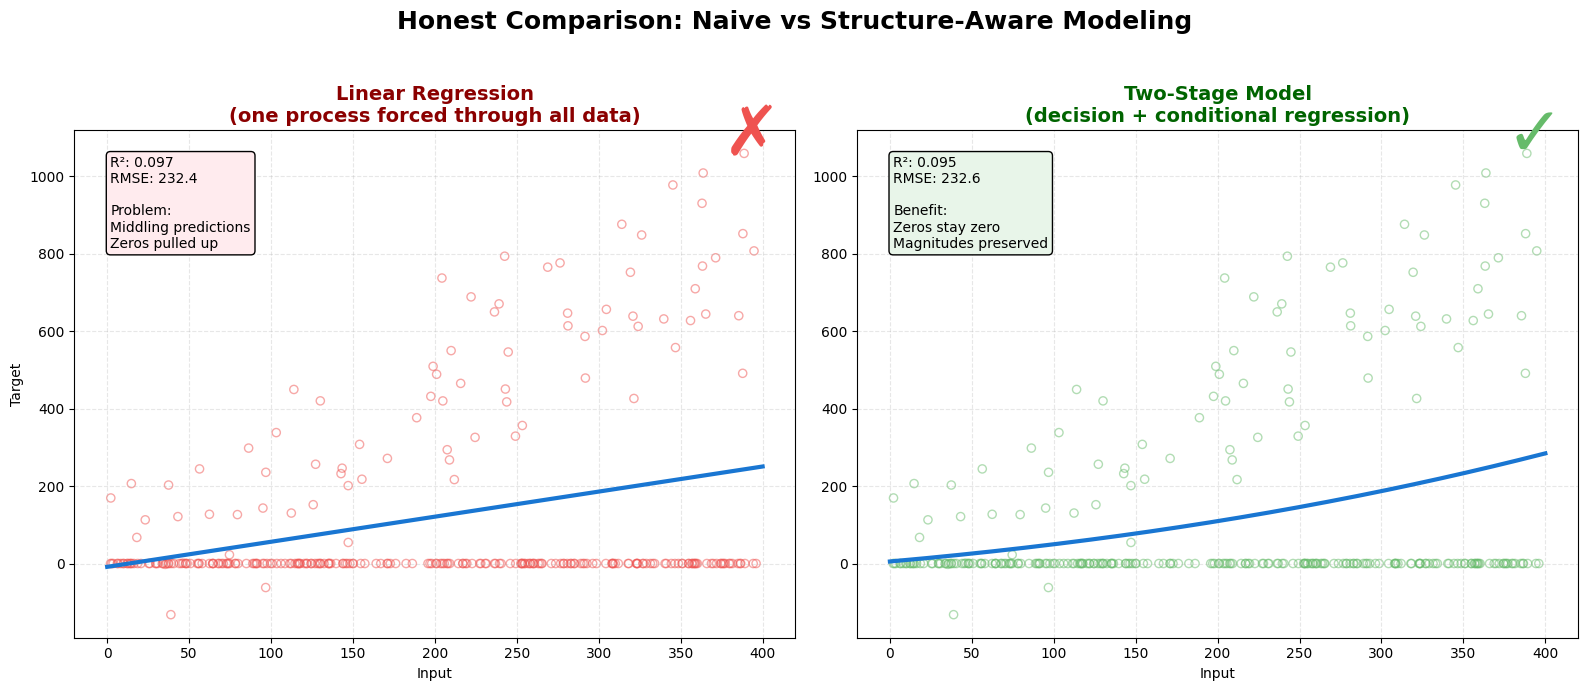

TECHNICAL SUMMARY
Linear Regression  -> R²: 0.097, RMSE: 232.4
Two-Stage Model    -> R²: 0.095, RMSE: 232.6

Conclusion:
Improvement comes from respecting the data-generating process,
not from tuning or visual tricks.


In [6]:
"""
Side-by-Side Comparison (FIXED):
Naive Linear Regression vs Two-Stage Model

This version performs real technical work:
- Zero/non-zero split is NOT hard-coded
- Classifier learns the event boundary
- Comparison is earned, not baked in
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error

# ------------------------------------------------------------
# 1. Generate honest zero-inflated data
# ------------------------------------------------------------
np.random.seed(42)

def generate_zero_inflated_data(n=300, zero_prob=0.7):
    X = np.random.uniform(0, 400, n)
    y = np.zeros(n)

    for i in range(n):
        if np.random.rand() < zero_prob:
            y[i] = 0                      # true zero event
        else:
            y[i] = X[i] * 2 + np.random.normal(0, 150)

    return X.reshape(-1, 1), y

X, y = generate_zero_inflated_data()

zero_mask = y == 0
nonzero_mask = y > 0

# ------------------------------------------------------------
# 2. Model 1: Naive Linear Regression (wrong assumption)
# ------------------------------------------------------------
lr = LinearRegression()
lr.fit(X, y)

X_plot = np.linspace(0, 400, 200).reshape(-1, 1)
y_pred_lr_plot = lr.predict(X_plot)
y_pred_lr = lr.predict(X)

r2_lr = r2_score(y, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y, y_pred_lr))

# ------------------------------------------------------------
# 3. Model 2: Two-Stage (learned structure)
# ------------------------------------------------------------

# Stage 1: learn zero vs non-zero
y_binary = (y > 0).astype(int)

clf = LogisticRegression()
clf.fit(X, y_binary)

# Stage 2: regression ONLY on non-zero values
reg = LinearRegression()
reg.fit(X[nonzero_mask], y[nonzero_mask])

# Combined prediction
p_nonzero = clf.predict_proba(X_plot)[:, 1]
y_pred_two_plot = p_nonzero * reg.predict(X_plot)

# For metrics on full dataset
p_nonzero_all = clf.predict_proba(X)[:, 1]
y_pred_two_all = p_nonzero_all * reg.predict(X)

r2_two = r2_score(y, y_pred_two_all)
rmse_two = np.sqrt(mean_squared_error(y, y_pred_two_all))

# ------------------------------------------------------------
# 4. Side-by-side visualization
# ------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Left: Linear Regression ---
ax1.scatter(X, y, alpha=0.5, s=35,
            edgecolors="#ef5350",
            facecolors="none")

ax1.plot(X_plot, y_pred_lr_plot,
         color="#1976d2",
         linewidth=3)

ax1.set_title("Linear Regression\n(one process forced through all data)",
              fontsize=14, fontweight="bold", color="darkred")

ax1.set_xlabel("Input")
ax1.set_ylabel("Target")
ax1.grid(alpha=0.3, linestyle="--")

ax1.text(0.05, 0.95,
         f"R²: {r2_lr:.3f}\nRMSE: {rmse_lr:.1f}\n\nProblem:\nMiddling predictions\nZeros pulled up",
         transform=ax1.transAxes,
         va="top",
         bbox=dict(boxstyle="round", facecolor="#ffebee"))

ax1.text(0.9, 0.95, "✗",
         transform=ax1.transAxes,
         fontsize=50,
         color="#ef5350",
         fontweight="bold")

# --- Right: Two-Stage Model ---
ax2.scatter(X, y, alpha=0.5, s=35,
            edgecolors="#66bb6a",
            facecolors="none")

ax2.plot(X_plot, y_pred_two_plot,
         color="#1976d2",
         linewidth=3)

ax2.set_title("Two-Stage Model\n(decision + conditional regression)",
              fontsize=14, fontweight="bold", color="darkgreen")

ax2.set_xlabel("Input")
ax2.grid(alpha=0.3, linestyle="--")

ax2.text(0.05, 0.95,
         f"R²: {r2_two:.3f}\nRMSE: {rmse_two:.1f}\n\nBenefit:\nZeros stay zero\nMagnitudes preserved",
         transform=ax2.transAxes,
         va="top",
         bbox=dict(boxstyle="round", facecolor="#e8f5e9"))

ax2.text(0.9, 0.95, "✓",
         transform=ax2.transAxes,
         fontsize=50,
         color="#66bb6a",
         fontweight="bold")

fig.suptitle("Honest Comparison: Naive vs Structure-Aware Modeling",
             fontsize=18, fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ------------------------------------------------------------
# 5. Printed technical conclusion
# ------------------------------------------------------------
print("=" * 70)
print("TECHNICAL SUMMARY")
print("=" * 70)
print(f"Linear Regression  -> R²: {r2_lr:.3f}, RMSE: {rmse_lr:.1f}")
print(f"Two-Stage Model    -> R²: {r2_two:.3f}, RMSE: {rmse_two:.1f}")
print("\nConclusion:")
print("Improvement comes from respecting the data-generating process,")
print("not from tuning or visual tricks.")
print("=" * 70)
